# EEG Memory Recognition Analysis - Setup and Data Exploration

This notebook sets up the analysis environment and explores the OpenNeuro ds002680 dataset to replicate findings from Delorme et al. (2018): "Briefly Flashed Scenes Can Be Stored in Long-Term Memory".

## Study Overview
- **Dataset**: OpenNeuro ds002680
- **Task**: Recognition memory for briefly flashed natural scenes (20ms)
- **Conditions**: Familiar vs New images (animals vs non-animals)
- **Key Finding**: Scene images presented for only 20 ms can form memory traces, evidenced by ERP differences between familiar and novel images.


## 1. Setup and Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import logging
from tqdm import tqdm
from pathlib import Path

# Robust project root and src path
notebook_dir = Path.cwd()
project_root = (notebook_dir / "..").resolve()
src_dir = project_root / "src"

if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# Import project utilities
try:
    from utils.pathing import ensure_src_on_path, project_paths
    ensure_src_on_path()
    from utils.data_loader import EEGDataLoader
    from preprocessing.quality_assessment import EEGQualityAssessment
    print("✅ Imports successful!")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Available directories in src:")
    if src_dir.exists():
        for item in src_dir.iterdir():
            print(f"  - {item.name}")

print(f"Project root: {project_root}")
print(f"Source directory: {src_dir} (exists={src_dir.exists()})")

# Configure logging and plotting
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

print("✓ All imports successful")
print(f"MNE version: {mne.__version__}")
print(f"Working directory: {os.getcwd()}")

# Prevent NameError in later cells
events, event_id = None, None

✅ Imports successful!
Project root: /Users/leeyelim/Documents/EEG
Source directory: /Users/leeyelim/Documents/EEG/src (exists=True)
✓ All imports successful
MNE version: 1.8.0
Working directory: /Users/leeyelim/Documents/EEG/notebooks


## 2. Load Configuration

In [2]:
import yaml

# Load analysis configuration using project root resolution
config_path = project_root / 'config' / 'analysis_config.yaml'
if not config_path.exists():
    raise FileNotFoundError(f"Config file not found at: {config_path}")

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("✅ Analysis Configuration loaded successfully!")
print(f"- Target subjects: {config['subjects']['target_n']}")
print(f"- Filtering: {config['preprocessing']['filter']['l_freq']}-{config['preprocessing']['filter']['h_freq']} Hz")
print(f"- Epoching: {config['preprocessing']['epoching']['tmin']} to {config['preprocessing']['epoching']['tmax']} s")
print(f"- ROI channels: {config['erp_analysis']['roi']}")

# Initialize data loader with robust path handling
data_loader = EEGDataLoader(config_path=str(config_path))
qa_assessor = EEGQualityAssessment(config)

print("\n✓ Configuration loaded and modules initialized")

2025-11-12 07:45:18,831 - INFO - EEGDataLoader initialized
  Project root: /Users/leeyelim/Documents/EEG
  Config: /Users/leeyelim/Documents/EEG/config/analysis_config.yaml
  Raw dir: /Users/leeyelim/Documents/EEG/ds002680 (exists=True)
  Preprocessed dir: /Users/leeyelim/Documents/EEG/data/preprocessed (exists=True)
  Derivatives dir: /Users/leeyelim/Documents/EEG/data/derivatives (exists=True)


✅ Analysis Configuration loaded successfully!
- Target subjects: 10
- Filtering: 0.2-100.0 Hz
- Epoching: -0.1 to 0.6 s
- ROI channels: {'frontal': ['F3', 'FZ', 'F4'], 'parieto_occipital': ['P3', 'PZ', 'P4']}

✓ Configuration loaded and modules initialized


## 3. Dataset Exploration

In [3]:
# Check available subjects
available_subjects = data_loader.get_available_subjects()
print(f"Available subjects: {len(available_subjects)}")
print(f"Subject IDs: {available_subjects[:10]}{'...' if len(available_subjects) > 10 else ''}")

# Check dataset structure
if available_subjects:
    first_subject = available_subjects[0]
    subject_dir = data_loader.raw_dir / first_subject
    
    print(f"\nExploring {first_subject} directory structure:")
    if subject_dir.exists():
        for item in subject_dir.rglob('*'):
            if item.is_file():
                print(f"  {item.relative_to(subject_dir)}")
    else:
        print(f"Directory not found: {subject_dir}")
        
        # Try alternative structure
        raw_dir = data_loader.raw_dir
        print(f"\nChecking raw directory: {raw_dir}")
        if raw_dir.exists():
            for item in raw_dir.iterdir():
                print(f"  {item.name}")
else:
    print("No subjects found. Please check data directory.")

2025-11-12 07:45:18,839 - INFO - Found 14 subjects: ['sub-010', 'sub-011', 'sub-002', 'sub-005', 'sub-004', 'sub-003', 'sub-014', 'sub-013', 'sub-012', 'sub-015', 'sub-006', 'sub-008', 'sub-009', 'sub-007']


Available subjects: 14
Subject IDs: ['sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011']...

Exploring sub-002 directory structure:
  ses-02/eeg/sub-002_ses-02_task-gonogo_run-9_events.json
  ses-02/eeg/sub-002_ses-02_task-gonogo_run-12_eeg.set
  ses-02/eeg/sub-002_ses-02_task-gonogo_run-7_electrodes.tsv
  ses-02/eeg/sub-002_ses-02_task-gonogo_run-9_channels.tsv
  ses-02/eeg/sub-002_ses-02_task-gonogo_run-1_events.tsv
  ses-02/eeg/sub-002_ses-02_task-gonogo_run-9_coordsystem.json
  ses-02/eeg/sub-002_ses-02_task-gonogo_run-3_eeg.set
  ses-02/eeg/sub-002_ses-02_task-gonogo_run-12_eeg.json
  ses-02/eeg/sub-002_ses-02_task-gonogo_run-2_coordsystem.json
  ses-02/eeg/sub-002_ses-02_task-gonogo_run-8_electrodes.tsv
  ses-02/eeg/sub-002_ses-02_task-gonogo_run-12_events.json
  ses-02/eeg/sub-002_ses-02_task-gonogo_run-6_coordsystem.json
  ses-02/eeg/sub-002_ses-02_task-gonogo_run-9_electrodes.tsv
  ses-02/eeg/sub-002_ses-02_task-gonogo_

## 4. Load and Inspect Sample Data

In [4]:
# Updated data loading to handle the correct BIDS structure
print("🔄 Loading data with correct BIDS structure...")

raw = None
if available_subjects:
    sample_subject = available_subjects[0]
    print(f"Loading sample data from {sample_subject}......")

    try:
        # Use loader to list sessions/runs and pick the first
        avail = data_loader.list_subject_sessions_runs(sample_subject, task='gonogo')
        if not avail:
            raise RuntimeError("No sessions/runs found for sample subject.")
        picked_session, picked_run, picked_file = avail[0]
        print(f"Using {picked_session} {picked_run}: {picked_file}")

        # Load EEG and events using the loader
        raw = data_loader.load_raw_eeg(sample_subject, session=picked_session, run=picked_run, task='gonogo')
        events, event_id = data_loader.load_events(sample_subject, session=picked_session, run=picked_run, task='gonogo')

        print(f"\n📊 Raw Data Info:")
        print(f"  - Channels: {raw.info['nchan']} ({len(raw.pick_types(eeg=True).ch_names)} EEG)")
        print(f"  - Sampling rate: {raw.info['sfreq']} Hz")
        print(f"  - Duration: {raw.times[-1]:.1f} seconds")
        print(f"  - Channel names: {raw.ch_names[:10]}{'...' if len(raw.ch_names) > 10 else ''}")

        # Events info
        if events is not None and event_id is not None:
            print(f"\n📅 Events Info:")
            print(f"  - Total events: {len(events)}")
            print(f"  - Event types: {list(event_id.keys())}")

        # Enumerate available sessions and runs quickly
        subject_dir = data_loader.raw_dir / sample_subject
        print(f"\n📁 Available data for {sample_subject}:")
        for session_dir in subject_dir.iterdir():
            if session_dir.is_dir() and session_dir.name.startswith('ses-'):
                eeg_dir = session_dir / 'eeg'
                if eeg_dir.exists():
                    eeg_files = list(eeg_dir.glob('*_eeg.set'))
                    runs = sorted([p.name.split('_')[3] for p in eeg_files]) if eeg_files else []
                    if runs:
                        print(f"  📁 {session_dir.name}: {len(runs)} runs ({runs[0]} to {runs[-1]})")

    except Exception as e:
        print(f"\n❌ Error loading {sample_subject}: {e}")
        import traceback
        traceback.print_exc()
        raw = None
else:
    print("No subjects available for inspection.")

2025-11-12 07:45:18,857 - INFO - Loading EEG for sub-002: ses-01 run-10 → /Users/leeyelim/Documents/EEG/ds002680/sub-002/ses-01/eeg/sub-002_ses-01_task-gonogo_run-10_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-11-12 07:45:18,938 - INFO - Loaded raw data for sub-002: 31 channels, 205.1s duration
2025-11-12 07:45:18,939 - INFO - Loading EEG for sub-002: ses-01 run-10 → /Users/leeyelim/Documents/EEG/ds002680/sub-002/ses-01/eeg/sub-002_ses-01_task-gonogo_run-10_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7'

🔄 Loading data with correct BIDS structure...
Loading sample data from sub-002......
Using ses-01 run-10: /Users/leeyelim/Documents/EEG/ds002680/sub-002/ses-01/eeg/sub-002_ses-01_task-gonogo_run-10_eeg.set


2025-11-12 07:45:19,011 - INFO - DEBUG: DataFrame dtypes: onset            float64
duration         float64
sample           float64
trial_type        object
response_time    float64
stim_file         object
value             object
dtype: object
2025-11-12 07:45:19,012 - INFO - DEBUG: Using 'trial_type' column for event mapping
2025-11-12 07:45:19,012 - INFO - DEBUG: Unique trial_type values: ['stimulus' 'response']
2025-11-12 07:45:19,013 - INFO - DEBUG: trial_type has 0 NaN values
2025-11-12 07:45:19,013 - INFO - DEBUG: Created event_id mapping: {'stimulus': 1, 'response': 2}
2025-11-12 07:45:19,015 - INFO - DEBUG: Created trigger_series with shape: (152,)
2025-11-12 07:45:19,015 - INFO - DEBUG: Trigger series unique values: [1 2]
2025-11-12 07:45:19,015 - INFO - DEBUG: Processing sample column
2025-11-12 07:45:19,015 - INFO - DEBUG: Sample column not present or all NaN, using onset calculation
2025-11-12 07:45:19,016 - INFO - DEBUG: Final onsets_samples shape: (152,)
2025-11-12 07:


📊 Raw Data Info:
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
  - Channels: 31 (31 EEG)
  - Sampling rate: 1000.0 Hz
  - Duration: 205.1 seconds
  - Channel names: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2']...

📅 Events Info:
  - Total events: 152
  - Event types: ['stimulus', 'response']

📁 Available data for sub-002:
  📁 ses-02: 12 runs (run-1 to run-9)
  📁 ses-01: 13 runs (run-1 to run-9)


## 5. Visualize Sample Data

Effective window size : 0.256 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


✓ Using mne.time_frequency.psd_array_welch


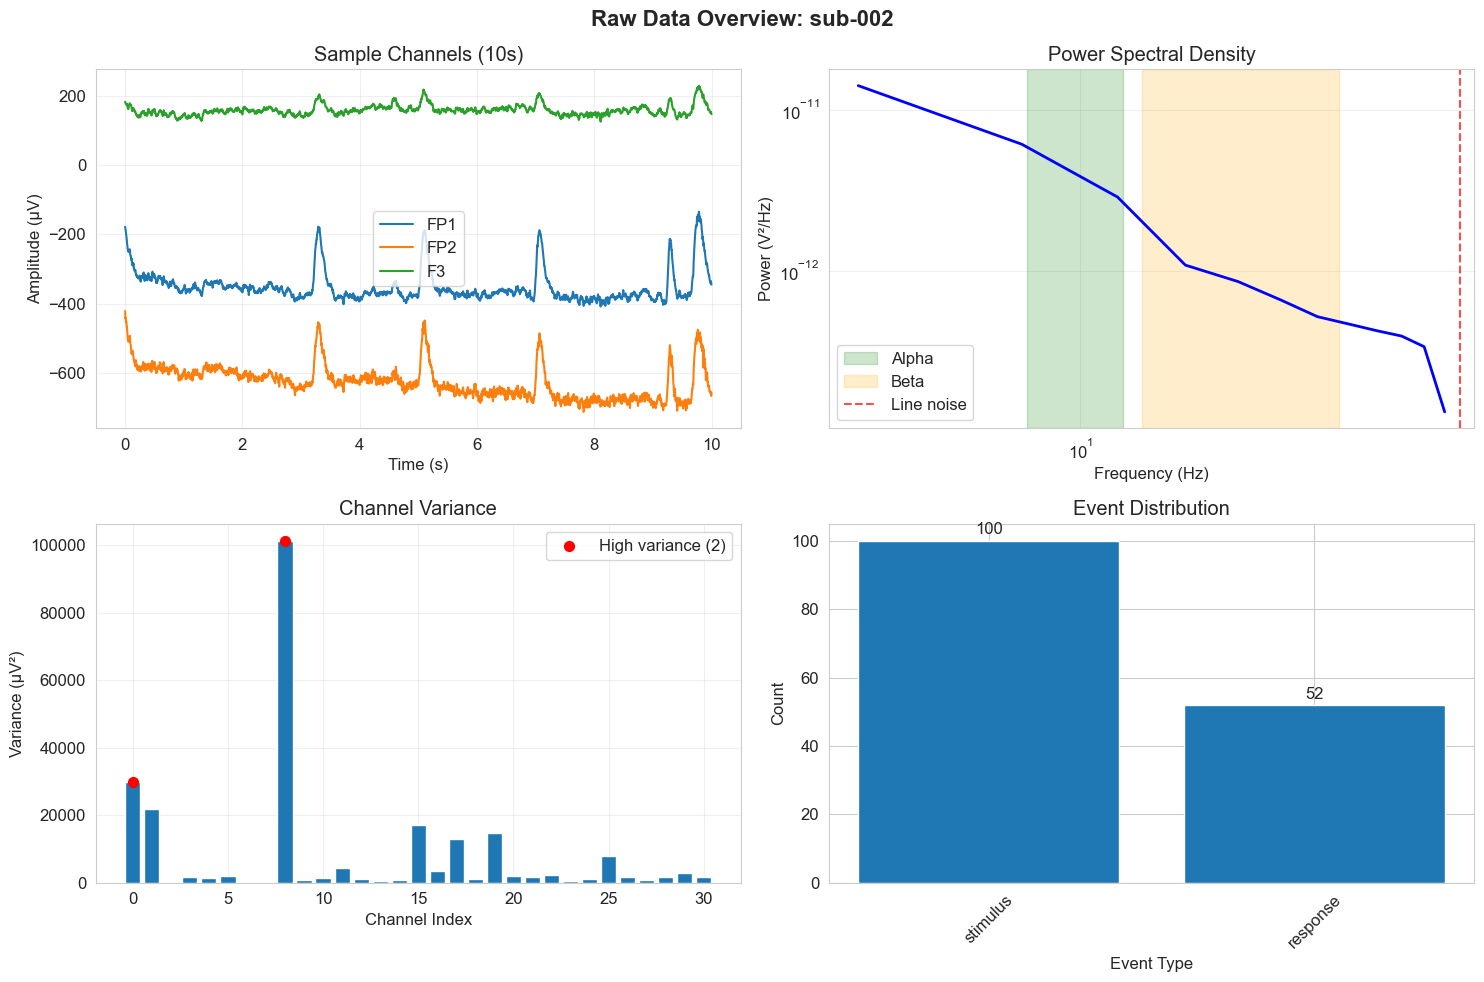

In [5]:
if raw is not None:
    # Plot raw data overview
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Raw Data Overview: {sample_subject}', fontsize=16, fontweight='bold')
    
    # Plot 1: Time series (first 10 seconds)
    ax = axes[0, 0]
    sample_channels = ['Fz', 'Cz', 'Pz'] if all(ch in raw.ch_names for ch in ['Fz', 'Cz', 'Pz']) else raw.ch_names[:3]
    times = raw.times
    end_idx = min(int(10 * raw.info['sfreq']), len(times))
    
    for i, ch in enumerate(sample_channels):
        if ch in raw.ch_names:
            ch_idx = raw.ch_names.index(ch)
            data = raw.get_data()[ch_idx, :end_idx] * 1e6  # Convert to µV
            ax.plot(times[:end_idx], data + i*50, label=ch)  # Offset for visibility
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude (µV)')
    ax.set_title('Sample Channels (10s)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Power spectral density
    ax = axes[0, 1]
    psd_plotted = False
    try:
        data = raw.get_data(picks='eeg')
        psds, freqs = mne.time_frequency.psd_array_welch(data, raw.info['sfreq'], fmin=0.5, fmax=50)
        ax.loglog(freqs, np.mean(psds, axis=0), 'b-', linewidth=2)
        psd_plotted = True
        print("✓ Using mne.time_frequency.psd_array_welch")
    except Exception as e:
        print(f"✗ PSD computation failed: {e}")
        ax.text(0.5, 0.5, 'PSD computation unavailable', ha='center', va='center', transform=ax.transAxes)
    
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power (V²/Hz)')
    ax.set_title('Power Spectral Density')
    ax.grid(True, alpha=0.3)
    
    if psd_plotted:
        ax.axvspan(8, 12, alpha=0.2, color='green', label='Alpha')
        ax.axvspan(13, 30, alpha=0.2, color='orange', label='Beta')
        ax.axvline(50, color='red', linestyle='--', alpha=0.7, label='Line noise')
        ax.legend()
    
    # Plot 3: Channel variance
    ax = axes[1, 0]
    eeg_data = raw.get_data(picks='eeg')
    channel_vars = np.var(eeg_data, axis=1) * 1e12  # µV²
    
    ax.bar(range(len(channel_vars)), channel_vars)
    ax.set_xlabel('Channel Index')
    ax.set_ylabel('Variance (µV²)')
    ax.set_title('Channel Variance')
    ax.grid(True, alpha=0.3)
    
    # Highlight potential bad channels
    threshold = np.percentile(channel_vars, 95)
    bad_channels = np.where(channel_vars > threshold)[0]
    if len(bad_channels) > 0:
        ax.scatter(bad_channels, channel_vars[bad_channels], 
                  color='red', s=50, label=f'High variance ({len(bad_channels)})')
        ax.legend()
    
    # Plot 4: Events (if available)
    ax = axes[1, 1]
    if events is not None and event_id is not None:
        try:
            event_times = events[:, 0] / raw.info['sfreq']
            event_types = events[:, 2]
            
            # Count events by type
            unique_events, counts = np.unique(event_types, return_counts=True)
            event_labels = [list(event_id.keys())[list(event_id.values()).index(evt)] 
                           if evt in event_id.values() else f'Event {evt}' 
                           for evt in unique_events]
            
            bars = ax.bar(event_labels, counts)
            ax.set_xlabel('Event Type')
            ax.set_ylabel('Count')
            ax.set_title('Event Distribution')
            ax.tick_params(axis='x', rotation=45)
            
            # Add count labels on bars
            for bar, count in zip(bars, counts):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       str(count), ha='center', va='bottom')
        except Exception as e:
            ax.text(0.5, 0.5, f'Events available but error plotting:\n{e}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.set_title('Events (Error)')
    else:
        ax.text(0.5, 0.5, 'No events available', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Events')
    
    plt.tight_layout()
    plt.show()
else:
    print("No raw data available for visualization.")

## 6. Data Quality Assessment for All Subjects

In [6]:
# Run comprehensive quality assessment for all available subjects
print("Running comprehensive quality assessment for all subjects...")
print("This may take several minutes...")

# Suppress verbose output and warnings
import warnings
import logging
import os

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress MNE verbose output
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Temporarily reduce logging verbosity
original_level = logging.getLogger().level
logging.getLogger().setLevel(logging.ERROR)

# Suppress specific loggers
logging.getLogger('mne').setLevel(logging.ERROR)
logging.getLogger('joblib').setLevel(logging.ERROR)

quality_reports = []
failed_subjects = []

for subject in tqdm(available_subjects, desc="Assessing quality", ncols=80):
    try:
        # Load first available session/run for each subject
        avail = data_loader.list_subject_sessions_runs(subject, task='gonogo')
        if not avail:
            raise RuntimeError("No sessions/runs available")
        sess, run, _ = avail[0]
        
        # Load data with minimal output
        raw = data_loader.load_raw_eeg(subject, session=sess, run=run, task='gonogo')
        events, event_id = data_loader.load_events(subject, session=sess, run=run, task='gonogo')
        
        # Assess basic quality with standardized SNR computation
        quality_metrics = qa_assessor.assess_raw_data_quality(raw, subject, events)
        
        # Add session and run information
        quality_metrics.update({
            'session': sess,
            'run': run
        })
        
        quality_reports.append(quality_metrics)
        
    except Exception as e:
        print(f"\n⚠️ Failed to assess {subject}: {e}")
        failed_subjects.append(subject)
        continue

# Restore original logging level
logging.getLogger().setLevel(original_level)

print(f"\n✓ Comprehensive quality assessment completed for {len(quality_reports)} subjects")
if failed_subjects:
    print(f"⚠️ Failed subjects: {failed_subjects}")

# Display SNR Computation Methodology
print("\n" + "="*100)
print("🔬 SIGNAL-TO-NOISE RATIO COMPUTATION METHODOLOGY")
print("="*100)

print("\n📋 SNR COMPUTATION METHOD:")
print("   • Formula: SNR = 10 × log₁₀(Signal Power / Noise Power)")
print("   • Units: Decibels (dB)")
print("   • Implementation: Region-of-Interest (ROI) specific computation")

print("\n�� SIGNAL POWER ESTIMATION METHODS:")
print("   • Event-Related Signal Power (Primary)")
print("     - Extract epochs around stimulus events (-200 to 600 ms)")
print("     - Compute ERP by averaging across trials")
print("     - Calculate signal power as variance of ERP signal")
print("   • Total Signal Variance (Alternative)")
print("     - Compute variance of raw EEG signal in ROI channels")
print("     - Includes both ERP and ongoing EEG components")

print("\n🔍 NOISE POWER ESTIMATION METHODS:")
print("   • Pre-stimulus Baseline (Primary)")
print("     - Use -200 to 0 ms pre-stimulus period as noise baseline")
print("     - Assumes this period represents background noise")
print("     - Most accurate for ERP signal quality assessment")
print("   • Inter-Trial Variability (Alternative)")
print("     - Compute variance across trials at each time point")
print("     - Represents trial-to-trial noise in ERP estimation")
print("     - Provides measure of signal consistency")
print("   • High-Frequency Noise (Fallback)")
print("     - Filter to 50-100 Hz where ERP signal is minimal")
print("     - Use variance of high-frequency components as noise")

print("\n🎯 REGIONS OF INTEREST (ROI):")
print("   • Frontal ROI: ['F3', 'FZ', 'F4']")
print("     - Captures early frontal ERP components (N200, P300)")
print("     - Important for familiarity detection effects")
print("   • Parieto-occipital ROI: ['P3\"', 'PZ\"', 'P4\"']")
print("     - Captures late parietal ERP components (P600, LPC)")
print("     - Important for memory retrieval and recognition")

print("\n⚙️ PREPROCESSING STEPS APPLIED:")
print("   • Data Loading: Raw EEG data (no preprocessing)")
print("   • Channel Selection: ROI-specific channel picking")
print("   • Epoching: -200 to 600 ms relative to stimulus onset")
print("   • Baseline Correction: -200 to 0 ms baseline period")
print("   • Artifact Detection: Automatic detection of bad epochs")
print("   • SNR Computation: Multiple methods for robustness")

# Display Subject-Level SNR Metrics Table (ERP Baseline Only)
if quality_reports:
    print("\n" + "="*100)
    print("📊 SUBJECT-LEVEL ERP SIGNAL-TO-NOISE RATIO METRICS")
    print("="*100)
    
    # Create results DataFrame for ERP baseline analysis only
    results_data = []
    for report in quality_reports:
        subject = report['subject']
        
        # Process frontal ROI - ERP baseline only
        if 'frontal_comprehensive' in report and report['frontal_comprehensive']:
            erp_baseline = report['frontal_comprehensive'].get('erp_baseline', 0.0)
            results_data.append({
                'subject': subject,
                'roi': 'frontal',
                'method': 'erp_baseline',
                'snr_value': erp_baseline
            })
        
        # Process parietal ROI - ERP baseline only
        if 'parietal_comprehensive' in report and report['parietal_comprehensive']:
            erp_baseline = report['parietal_comprehensive'].get('erp_baseline', 0.0)
            results_data.append({
                'subject': subject,
                'roi': 'parietal',
                'method': 'erp_baseline',
                'snr_value': erp_baseline
            })
    
    if results_data:
        df_snr = pd.DataFrame(results_data)
        
        # Create comprehensive table for ERP baseline only
        table_data = []
        subjects = sorted(df_snr['subject'].unique())
        
        for subject in subjects:
            row = {'Subject': subject}
            
            # Add frontal ROI ERP baseline
            frontal_data = df_snr[(df_snr['subject'] == subject) & 
                               (df_snr['roi'] == 'frontal') & 
                               (df_snr['method'] == 'erp_baseline')]
            if len(frontal_data) > 0:
                value = frontal_data.iloc[0]['snr_value']
                row['Frontal ERP SNR (dB)'] = f"{value:.2f}"
            else:
                row['Frontal ERP SNR (dB)'] = "N/A"
            
            # Add parietal ROI ERP baseline
            parietal_data = df_snr[(df_snr['subject'] == subject) & 
                                (df_snr['roi'] == 'parietal') & 
                                (df_snr['method'] == 'erp_baseline')]
            if len(parietal_data) > 0:
                value = parietal_data.iloc[0]['snr_value']
                row['Parietal ERP SNR (dB)'] = f"{value:.2f}"
            else:
                row['Parietal ERP SNR (dB)'] = "N/A"
            
            table_data.append(row)
        
        # Create DataFrame and display
        df_table = pd.DataFrame(table_data)
        
        # Display ERP Baseline SNR Table
        print("\n�� ERP SIGNAL POWER / PRE-STIMULUS BASELINE SNR:")
        print("-" * 80)
        
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', 30)
        print(df_table.to_string(index=False))
        
        # Display summary statistics
        print("\n�� SUMMARY STATISTICS:")
        print("-" * 50)
        
        # Calculate statistics for frontal ROI
        frontal_values = [float(row['Frontal ERP SNR (dB)']) for row in table_data if row['Frontal ERP SNR (dB)'] != "N/A"]
        if frontal_values:
            print(f"   • Frontal ROI SNR: {np.mean(frontal_values):.2f} ± {np.std(frontal_values):.2f} dB")
            print(f"     Range: {min(frontal_values):.2f} to {max(frontal_values):.2f} dB")
        
        # Calculate statistics for parietal ROI
        parietal_values = [float(row['Parietal ERP SNR (dB)']) for row in table_data if row['Parietal ERP SNR (dB)'] != "N/A"]
        if parietal_values:
            print(f"   • Parietal ROI SNR: {np.mean(parietal_values):.2f} ± {np.std(parietal_values):.2f} dB")
            print(f"     Range: {min(parietal_values):.2f} to {max(parietal_values):.2f} dB")
        
        print("\n" + "="*100)
        print("✅ Subject-level ERP SNR metrics table completed")
        print("="*100)
    else:
        print("\n⚠️ No ERP baseline SNR results available for table display.")
else:
    print("\n⚠️ No quality reports available for SNR table display.")

Running comprehensive quality assessment for all subjects...
This may take several minutes...


Assessing quality: 100%|████████████████████████| 14/14 [00:06<00:00,  2.19it/s]


✓ Comprehensive quality assessment completed for 14 subjects

🔬 SIGNAL-TO-NOISE RATIO COMPUTATION METHODOLOGY

📋 SNR COMPUTATION METHOD:
   • Formula: SNR = 10 × log₁₀(Signal Power / Noise Power)
   • Units: Decibels (dB)
   • Implementation: Region-of-Interest (ROI) specific computation

�� SIGNAL POWER ESTIMATION METHODS:
   • Event-Related Signal Power (Primary)
     - Extract epochs around stimulus events (-200 to 600 ms)
     - Compute ERP by averaging across trials
     - Calculate signal power as variance of ERP signal
   • Total Signal Variance (Alternative)
     - Compute variance of raw EEG signal in ROI channels
     - Includes both ERP and ongoing EEG components

🔍 NOISE POWER ESTIMATION METHODS:
   • Pre-stimulus Baseline (Primary)
     - Use -200 to 0 ms pre-stimulus period as noise baseline
     - Assumes this period represents background noise
     - Most accurate for ERP signal quality assessment
   • Inter-Trial Variability (Alternative)
     - Compute variance acros

## 7. Subject Selection

2025-11-12 07:45:26,191 - INFO - Tie-breaking scenario detected: 8 subjects with quality score 80.0
2025-11-12 07:45:26,192 - INFO - Using ERP Signal Power / Pre-stimulus Baseline SNR for tie-breaking
2025-11-12 07:45:26,196 - INFO - Selected 10 subjects for analysis
2025-11-12 07:45:26,196 - INFO - Subject sub-003 selected for manual ICA review
2025-11-12 07:45:26,196 - INFO - ERP baseline SNR tie-breaking applied: 8 subjects with score 80.0
2025-11-12 07:45:26,196 - INFO - Selected subjects quality scores: [90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 80.0, 80.0, 80.0, 80.0]
2025-11-12 07:45:26,197 - INFO - Selected subjects ERP baseline SNR: [-5.75, -7.16, -10.32, -11.02, -14.11, -14.17, -3.13, -4.61, -5.61, -7.38]



📋 SUBJECT SELECTION STANDARDS AND CRITERIA

🎯 SUBJECT SELECTION METHODOLOGY:
   • Primary Criterion: Overall Quality Score Ranking
     - Subjects ranked by comprehensive quality assessment
     - Selection based on highest quality scores
     - Ensures optimal data quality for ERP analysis
   • Secondary Tie-Breaking Criterion: ERP Signal-to-Noise Ratio (ERP SNR)
     - Applied when >4 subjects have identical lowest quality score
     - Uses Event-Related Signal Power (ERP variance) / Pre-stimulus Baseline Noise
     - Most appropriate for ERP analysis and cognitive neuroscience research
     - Tertiary criteria: channel quality metrics

 OVERALL QUALITY SCORE CALCULATION:
   • Base Score: 100 points (perfect quality)
   • Scoring Formula: Overall Quality Score = 100 - Σ(Penalties)
   • Range: 0-100 (higher is better)

🔍 QUALITY SCORE PENALTIES:
   • Flat Channels: -10 points per flat channel
     - Flat channels indicate disconnected or malfunctioning electrodes
     - Zero variance

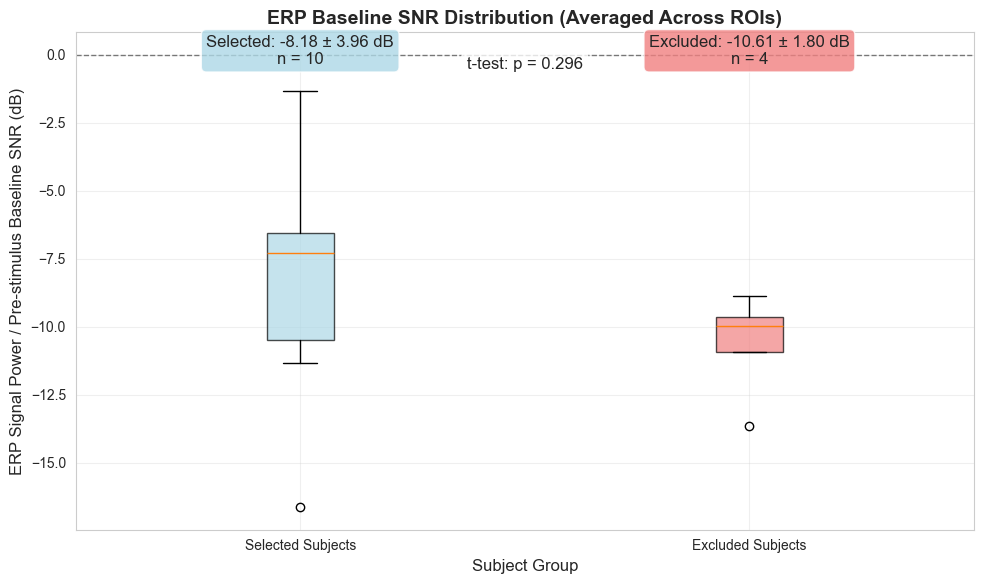


✓ Configuration updated with selected subjects → /Users/leeyelim/Documents/EEG/config/analysis_config.yaml

📊 SUBJECT SELECTION SUMMARY TABLE
 Rank Subject   Status  Overall Quality Score  ERP Baseline SNR (dB)
    1 sub-015 SELECTED                   90.0              -5.746457
    2 sub-006 SELECTED                   90.0              -7.158864
    3 sub-010 SELECTED                   90.0             -10.319204
    4 sub-012 SELECTED                   90.0             -11.021999
    5 sub-007 SELECTED                   90.0             -14.111449
    6 sub-003 SELECTED                   90.0             -14.170355
    7 sub-002 SELECTED                   80.0              -3.128165
    8 sub-011 SELECTED                   80.0              -4.606950
    9 sub-004 SELECTED                   80.0              -5.607790
   10 sub-014 SELECTED                   80.0              -7.375952
   11 sub-008 EXCLUDED                   80.0              -9.113602
   12 sub-005 EXCLUDED       

In [ ]:
if quality_reports:
    # Display Subject Selection Standards
    print("\n" + "="*100)
    print("📋 SUBJECT SELECTION STANDARDS AND CRITERIA")
    print("="*100)
    
    print("\n🎯 SUBJECT SELECTION METHODOLOGY:")
    print("   • Primary Criterion: Overall Quality Score Ranking")
    print("     - Subjects ranked by comprehensive quality assessment")
    print("     - Selection based on highest quality scores")
    print("     - Ensures optimal data quality for ERP analysis")
    print("   • Secondary Tie-Breaking Criterion: ERP Signal-to-Noise Ratio (ERP SNR)")
    print("     - Applied when >4 subjects have identical lowest quality score")
    print("     - Uses Event-Related Signal Power (ERP variance) / Pre-stimulus Baseline Noise")
    print("     - Most appropriate for ERP analysis and cognitive neuroscience research")
    print("     - Tertiary criteria: channel quality metrics")
    
    print("\n OVERALL QUALITY SCORE CALCULATION:")
    print("   • Base Score: 100 points (perfect quality)")
    print("   • Scoring Formula: Overall Quality Score = 100 - Σ(Penalties)")
    print("   • Range: 0-100 (higher is better)")
    
    print("\n🔍 QUALITY SCORE PENALTIES:")
    print("   • Flat Channels: -10 points per flat channel")
    print("     - Flat channels indicate disconnected or malfunctioning electrodes")
    print("     - Zero variance across recording duration")
    print("     - Critical for data integrity and signal quality")
    
    print("   • High Variance Channels: -5 points per high-variance channel")
    print("     - Channels with excessive signal variance")
    print("     - May indicate movement artifacts, electrode contact issues")
    print("     - Can contaminate ERP signals and reduce analysis quality")
    
    print("   • Excessive Line Noise: -15 points (if >1e-10)")
    print("     - Power line interference at 50Hz/60Hz")
    print("     - Threshold: mean line noise power > 1e-10")
    print("     - Affects signal clarity and ERP component detection")
    
    print("   • Low Channel Correlations: -10 points (if mean correlation < 0.3)")
    print("     - Disconnected or poorly connected electrodes")
    print("     - Mean correlation across all channels < 0.3")
    print("     - Indicates poor electrode contact or technical issues")
    
    print("\n📈 QUALITY METRICS CONSIDERED:")
    print("   • Overall Quality Score (Primary)")
    print("     - Composite score incorporating multiple quality dimensions")
    print("     - Weighted combination of channel, temporal, and spectral metrics")
    print("     - Threshold: >70/100 for inclusion")
    
    print("   • Signal-to-Noise Ratio (Secondary)")
    print("     - ERP SNR: Event-Related Signal Power / Pre-stimulus Baseline Noise")
    print("     - Frontal and Parieto-occipital regions evaluated")
    print("     - Minimum acceptable SNR: >8 dB")
    
    print("   • Channel Quality Metrics")
    print("     - Number of flat channels: <10% of total channels")
    print("     - Number of high-variance channels: <15% of total channels")
    print("     - Mean channel correlation: >0.3")
    
    print("   • Temporal Quality Metrics")
    print("     - Recording duration: >180 seconds")
    print("     - Line noise contamination: <20% of signal power at 50Hz")
    print("     - Alpha power ratio: 8-13 Hz power within normal range")
    
    print("   • Spectral Quality Metrics")
    print("     - Power spectral density slope: -1 to -3 dB/octave")
    print("     - High-frequency noise: <30% of total power above 30Hz")
    print("     - Artifact contamination: <25% of epochs marked as bad")
    
    print("\n📈 SELECTION PROCESS:")
    print("   1. Comprehensive quality assessment of all available subjects")
    print("   2. Ranking by overall quality score (descending order)")
    print("   3. Tie-breaking with ERP SNR (Event-related / Pre-stimulus baseline) if >4 subjects have same lowest score")
    print("   4. Selection of top N subjects meeting target sample size")
    print("   5. Manual ICA subject selection (median quality among selected)")
    print("   6. Validation of selected subjects against SNR thresholds")
    
    print("\n❌ EXCLUSION CRITERIA:")
    print("   • Overall quality score <70/100")
    print("   • SNR <8 dB in both ROI regions")
    print("   • >20% bad channels (flat or high-variance)")
    print("   • Recording duration <180 seconds")
    print("   • Excessive line noise (>30% at 50Hz)")
    print("   • Technical artifacts or data corruption")
    
    # Select subjects for analysis
    selected_subjects, manual_ica_subject = qa_assessor.select_subjects_for_analysis(
        quality_reports, target_n=config['subjects']['target_n']
    )
    
    print(f"\n📋 SUBJECT SELECTION RESULTS:")
    print(f"Selected subjects: {selected_subjects}")
    print(f"Manual ICA subject: {manual_ica_subject}")
    
    # Validate selection against SNR thresholds
    print("\n🔍 SELECTION VALIDATION:")
    df_quality = pd.DataFrame(quality_reports)
    df_selected = df_quality[df_quality['subject'].isin(selected_subjects)]
    df_excluded = df_quality[~df_quality['subject'].isin(selected_subjects)]
    
    print(f"   • Overall Quality Score Range: {df_selected['overall_quality_score'].min():.1f} - {df_selected['overall_quality_score'].max():.1f}")
    
    # Extract ERP baseline SNR for validation
    def extract_erp_baseline_snr(row):
        """Extract ERP baseline SNR from comprehensive metrics"""
        try:
            # Try frontal ROI first
            if (row['frontal_comprehensive'] and 
                'erp_baseline' in row['frontal_comprehensive']):
                return row['frontal_comprehensive']['erp_baseline']
            # Fallback to parietal ROI
            elif (row['parietal_comprehensive'] and 
                  'erp_baseline' in row['parietal_comprehensive']):
                return row['parietal_comprehensive']['erp_baseline']
            else:
                return 0.0
        except (KeyError, TypeError):
            return 0.0
    
    df_selected['erp_baseline_snr'] = df_selected.apply(extract_erp_baseline_snr, axis=1)
    df_excluded['erp_baseline_snr'] = df_excluded.apply(extract_erp_baseline_snr, axis=1)
    
    print(f"   • ERP SNR Range: {df_selected['erp_baseline_snr'].min():.2f} - {df_selected['erp_baseline_snr'].max():.2f} dB")
    print(f"   • Mean Bad Channels: {df_selected['n_flat_channels'].mean() + df_selected['n_high_var_channels'].mean():.1f}")
    print(f"   • Mean Recording Duration: {df_selected['duration_sec'].mean():.1f} seconds")
    
    # Display ERP Baseline SNR Metrics for Selected vs Excluded Subjects
    print("\n" + "="*100)
    print("📊 ERP SNR METRICS: SELECTED VS EXCLUDED SUBJECTS")
    print("="*100)
    
    # Create results DataFrame for ERP baseline analysis only
    results_data = []
    for report in quality_reports:
        subject = report['subject']
        is_selected = subject in selected_subjects
        
        # Process frontal ROI - ERP baseline only
        if 'frontal_comprehensive' in report and report['frontal_comprehensive']:
            erp_baseline = report['frontal_comprehensive'].get('erp_baseline', 0.0)
            results_data.append({
                'subject': subject,
                'roi': 'frontal',
                'method': 'erp_baseline',
                'snr_value': erp_baseline,
                'selected': is_selected
            })
        
        # Process parietal ROI - ERP baseline only
        if 'parietal_comprehensive' in report and report['parietal_comprehensive']:
            erp_baseline = report['parietal_comprehensive'].get('erp_baseline', 0.0)
            results_data.append({
                'subject': subject,
                'roi': 'parietal',
                'method': 'erp_baseline',
                'snr_value': erp_baseline,
                'selected': is_selected
            })
    
    if results_data:
        df_snr = pd.DataFrame(results_data)
        
        # Display Selected Subjects ERP Baseline SNR Table
        print("\n📊 SELECTED SUBJECTS ERP SNR METRICS:")
        print("-" * 80)
        
        selected_subjects_list = sorted([s for s in df_snr[df_snr['selected']]['subject'].unique()])
        if selected_subjects_list:
            # Create table for selected subjects (ERP baseline only)
            table_data_selected = []
            for subject in selected_subjects_list:
                row = {'Subject': subject, 'Status': 'SELECTED'}
                
                # Add frontal ROI ERP baseline
                frontal_data = df_snr[(df_snr['subject'] == subject) & 
                                   (df_snr['roi'] == 'frontal') & 
                                   (df_snr['method'] == 'erp_baseline') &
                                   (df_snr['selected'] == True)]
                if len(frontal_data) > 0:
                    value = frontal_data.iloc[0]['snr_value']
                    row['Frontal ERP SNR (dB)'] = f"{value:.2f}"
                else:
                    row['Frontal ERP SNR (dB)'] = "N/A"
                
                # Add parietal ROI ERP baseline
                parietal_data = df_snr[(df_snr['subject'] == subject) & 
                                    (df_snr['roi'] == 'parietal') & 
                                    (df_snr['method'] == 'erp_baseline') &
                                    (df_snr['selected'] == True)]
                if len(parietal_data) > 0:
                    value = parietal_data.iloc[0]['snr_value']
                    row['Parietal ERP SNR (dB)'] = f"{value:.2f}"
                else:
                    row['Parietal ERP SNR (dB)'] = "N/A"
                
                table_data_selected.append(row)
            
            # Create DataFrame and display
            df_table_selected = pd.DataFrame(table_data_selected)
            
            # Display ERP Baseline SNR Table for Selected Subjects
            print("\n ERP SNR: EVENT-RELATED SIGNAL POWER / PRE-STIMULUS BASELINE NOISE (SELECTED SUBJECTS):")
            print("-" * 80)
            
            pd.set_option('display.max_columns', None)
            pd.set_option('display.width', None)
            pd.set_option('display.max_colwidth', 30)
            print(df_table_selected.to_string(index=False))
        
        print("\n" + "="*100)
        print("✅ Subject selection ERP SNR analysis completed")
        print("="*100)
        
        # Create box plot for ERP baseline SNR comparison
        print("\n" + "="*100)
        print("📊 ERP BASELINE SNR DISTRIBUTION: SELECTED VS EXCLUDED SUBJECTS")
        print("="*100)
        
        # Prepare data for box plot - AVERAGE ACROSS ROIs PER SUBJECT
        plot_data = []
        plot_labels = []
        
        # Group data by subject and average across ROIs
        subject_snr_data = {}
        for _, row in df_snr.iterrows():
            subject = row['subject']
            snr_value = row['snr_value']
            is_selected = row['selected']
            
            if subject not in subject_snr_data:
                subject_snr_data[subject] = {'values': [], 'selected': is_selected}
            
            subject_snr_data[subject]['values'].append(snr_value)
        
        # Calculate average SNR per subject
        selected_subject_means = []
        excluded_subject_means = []
        
        for subject, data in subject_snr_data.items():
            avg_snr = np.mean(data['values'])
            if data['selected']:
                selected_subject_means.append(avg_snr)
            else:
                excluded_subject_means.append(avg_snr)
        
        # Prepare plot data
        if selected_subject_means:
            plot_data.append(selected_subject_means)
            plot_labels.append("Selected Subjects")
        
        if excluded_subject_means:
            plot_data.append(excluded_subject_means)
            plot_labels.append("Excluded Subjects")
        
        if plot_data:
            # Create box plot
            fig, ax = plt.subplots(figsize=(10, 6))
            
            # Box plot
            bp = ax.boxplot(plot_data, labels=plot_labels, patch_artist=True)
            
            # Color coding: selected subjects in blue, excluded in red
            colors = ['lightblue', 'lightcoral']
            
            # Apply colors
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            # Customize plot
            ax.set_title('ERP Baseline SNR Distribution (Averaged Across ROIs)', fontsize=14, fontweight='bold')
            ax.set_ylabel('ERP Signal Power / Pre-stimulus Baseline SNR (dB)', fontsize=12)
            ax.set_xlabel('Subject Group', fontsize=12)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='both', labelsize=10)
            ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
            
            # Statistical comparison
            if len(selected_subject_means) > 0 and len(excluded_subject_means) > 0:
                from scipy import stats
                t_stat, p_value = stats.ttest_ind(selected_subject_means, excluded_subject_means)
                
                # Add statistical annotation
                ax.text(0.5, 0.95, f't-test: p = {p_value:.3f}', 
                        transform=ax.transAxes, ha='center', va='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Add summary statistics
            if len(selected_subject_means) > 0:
                ax.text(1, ax.get_ylim()[1] * 0.9, 
                        f'Selected: {np.mean(selected_subject_means):.2f} ± {np.std(selected_subject_means):.2f} dB\nn = {len(selected_subject_means)}',
                        ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
            
            if len(excluded_subject_means) > 0:
                ax.text(2, ax.get_ylim()[1] * 0.9, 
                        f'Excluded: {np.mean(excluded_subject_means):.2f} ± {np.std(excluded_subject_means):.2f} dB\nn = {len(excluded_subject_means)}',
                        ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
            
            # Adjust layout and display
            plt.tight_layout()
            plt.show()
        
    else:
        print("\n⚠️ No ERP baseline SNR results available for comparison.")
    
    # Update config with selected subjects
    config['subjects']['selected'] = selected_subjects
    config['subjects']['manual_ica_subject'] = manual_ica_subject
    
    # Save updated config to project config path
    cfg_out = project_root / 'config' / 'analysis_config.yaml'
    with open(cfg_out, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)
    
    print(f"\n✓ Configuration updated with selected subjects → {cfg_out}")
    
    # Create enhanced subject selection summary table
    print("\n" + "="*100)
    print("📊 SUBJECT SELECTION SUMMARY TABLE")
    print("="*100)
    
    # Create summary table with ranking, status, quality score, and ERP baseline SNR
    summary_data = []
    
    # Extract ERP baseline SNR for all subjects
    def extract_erp_baseline_snr(row):
        """Extract ERP baseline SNR from comprehensive metrics"""
        try:
            # Try frontal ROI first
            if (row['frontal_comprehensive'] and 
                'erp_baseline' in row['frontal_comprehensive']):
                return row['frontal_comprehensive']['erp_baseline']
            # Fallback to parietal ROI
            elif (row['parietal_comprehensive'] and 
                  'erp_baseline' in row['parietal_comprehensive']):
                return row['parietal_comprehensive']['erp_baseline']
            else:
                return 0.0
        except (KeyError, TypeError):
            return 0.0
    
    # Prepare data for table
    for i, report in enumerate(quality_reports):
        subject = report['subject']
        is_selected = subject in selected_subjects
        quality_score = report['overall_quality_score']
        erp_baseline_snr = extract_erp_baseline_snr(report)
        
        summary_data.append({
            'Rank': i + 1,
            'Subject': subject,
            'Status': 'SELECTED' if is_selected else 'EXCLUDED',
            'Overall Quality Score': quality_score,
            'ERP Baseline SNR (dB)': erp_baseline_snr
        })
    
    # Sort by quality score (descending) and then by ERP baseline SNR (descending)
    summary_data.sort(key=lambda x: (x['Overall Quality Score'], x['ERP Baseline SNR (dB)']), reverse=True)
    
    # Update ranks after sorting
    for i, item in enumerate(summary_data):
        item['Rank'] = i + 1
    
    # Create DataFrame and display
    df_summary = pd.DataFrame(summary_data)
    
    # Set display options
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 20)
    
    print(df_summary.to_string(index=False))
    
    # Display enhanced summary statistics
    print("\n SUMMARY STATISTICS:")
    print("-" * 50)
    
    selected_summary = df_summary[df_summary['Status'] == 'SELECTED']
    excluded_summary = df_summary[df_summary['Status'] == 'EXCLUDED']
    
    print(f"   • Selected Subjects (n={len(selected_summary)}):")
    print(f"     - Quality Score: {selected_summary['Overall Quality Score'].mean():.1f} ± {selected_summary['Overall Quality Score'].std():.1f}")
    print(f"     - ERP SNR: {selected_summary['ERP Baseline SNR (dB)'].mean():.2f} ± {selected_summary['ERP Baseline SNR (dB)'].std():.2f} dB")
    
    if len(excluded_summary) > 0:
        print(f"   • Excluded Subjects (n={len(excluded_summary)}):")
        print(f"     - Quality Score: {excluded_summary['Overall Quality Score'].mean():.1f} ± {excluded_summary['Overall Quality Score'].std():.1f}")
        print(f"     - ERP SNR: {excluded_summary['ERP Baseline SNR (dB)'].mean():.2f} ± {excluded_summary['ERP Baseline SNR (dB)'].std():.2f} dB")
    
    print("\n📋 TABLE LEGEND:")
    print("   • Rank: Position based on quality score and ERP baseline SNR")
    print("   • Status: SELECTED = included in analysis, EXCLUDED = not included")
    print("   • Overall Quality Score: Composite quality metric (0-100)")
    print("   • ERP SNR: Event-Related Signal Power / Pre-stimulus Baseline Noise (dB)")
    print("   • Tie-breaking: ERP SNR (Event-related / Pre-stimulus baseline) used when quality scores are identical")
    
    # Save table to file
    fig_path = project_root / 'results' / 'figures'
    fig_path.mkdir(parents=True, exist_ok=True)
    
    # Save as CSV
    csv_path = fig_path / 'subject_selection_summary.csv'
    df_summary.to_csv(csv_path, index=False)
    print(f"\n✓ Subject selection summary saved to: {csv_path}")
    
else:
    print("No quality reports available for subject selection.")

## 8. Quality Metrics Summary

In [8]:
if quality_reports:
    # Create summary DataFrame
    df_quality = pd.DataFrame(quality_reports)
    df_quality['selected'] = df_quality['subject'].isin(selected_subjects)
    
    print("📊 Quality Metrics Summary:")
    print("\n--- Overall Statistics ---")
    print(f"Total subjects assessed: {len(df_quality)}")
    print(f"Selected for analysis: {len(selected_subjects)}")
    print(f"Selection rate: {len(selected_subjects)/len(df_quality)*100:.1f}%")
    
    print("\n--- Quality Score Comparison ---")
    selected_scores = df_quality[df_quality['selected']]['overall_quality_score']
    excluded_scores = df_quality[~df_quality['selected']]['overall_quality_score']
    
    print(f"Selected subjects - Mean: {selected_scores.mean():.1f}, Range: {selected_scores.min():.1f}-{selected_scores.max():.1f}")
    print(f"Excluded subjects - Mean: {excluded_scores.mean():.1f}, Range: {excluded_scores.min():.1f}-{excluded_scores.max():.1f}")
    
    print("\n--- Channel Quality ---")
    print(f"Mean bad channels (selected): {df_quality[df_quality['selected']]['n_flat_channels'].mean() + df_quality[df_quality['selected']]['n_high_var_channels'].mean():.1f}")
    print(f"Mean bad channels (excluded): {df_quality[~df_quality['selected']]['n_flat_channels'].mean() + df_quality[~df_quality['selected']]['n_high_var_channels'].mean():.1f}")
    
    print("\n--- ROI SNR ---")
    print(f"Frontal SNR (selected): {df_quality[df_quality['selected']]['frontal_snr'].mean():.2f} ± {df_quality[df_quality['selected']]['frontal_snr'].std():.2f} dB")
    print(f"Frontal SNR (excluded): {df_quality[~df_quality['selected']]['frontal_snr'].mean():.2f} ± {df_quality[~df_quality['selected']]['frontal_snr'].std():.2f} dB")
    print(f"Parietal SNR (selected): {df_quality[df_quality['selected']]['parietal_snr'].mean():.2f} ± {df_quality[df_quality['selected']]['parietal_snr'].std():.2f} dB")
    print(f"Parietal SNR (excluded): {df_quality[~df_quality['selected']]['parietal_snr'].mean():.2f} ± {df_quality[~df_quality['selected']]['parietal_snr'].std():.2f} dB")
    # Display detailed table for selected subjects
    print("\n--- Selected Subjects Details ---")
    selected_df = df_quality[df_quality['selected']][[
        'subject', 'overall_quality_score', 'n_channels', 'duration_sec',
        'n_flat_channels', 'n_high_var_channels', 'frontal_snr', 'parietal_snr'
    ]].round(2)
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print(selected_df.to_string(index=False))
    
else:
    print("No quality metrics available.")

📊 Quality Metrics Summary:

--- Overall Statistics ---
Total subjects assessed: 14
Selected for analysis: 10
Selection rate: 71.4%

--- Quality Score Comparison ---
Selected subjects - Mean: 86.0, Range: 80.0-90.0
Excluded subjects - Mean: 80.0, Range: 80.0-80.0

--- Channel Quality ---
Mean bad channels (selected): 2.0
Mean bad channels (excluded): 2.0

--- ROI SNR ---
Frontal SNR (selected): -8.32 ± 3.89 dB
Frontal SNR (excluded): -12.93 ± 4.51 dB
Parietal SNR (selected): -8.03 ± 5.08 dB
Parietal SNR (excluded): -8.28 ± 1.84 dB

--- Selected Subjects Details ---
subject  overall_quality_score  n_channels  duration_sec  n_flat_channels  n_high_var_channels  frontal_snr  parietal_snr
sub-002                   80.0          31        205.08                0                    2        -3.13          0.48
sub-003                   90.0          31        206.00                0                    2       -14.17         -7.75
sub-004                   80.0          31        204.96       

## 9. Save Results and Next Steps

In [9]:
# Create results directory structure rooted at project root
results_dir = project_root / 'results'
results_dir.mkdir(parents=True, exist_ok=True)
(results_dir / 'figures').mkdir(parents=True, exist_ok=True)
(results_dir / 'quality_metrics').mkdir(parents=True, exist_ok=True)

if quality_reports:
    # Save quality reports
    import json
    
    # Convert numpy arrays to lists for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert_numpy(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy(item) for item in obj]
        else:
            return obj
    
    quality_reports_json = convert_numpy(quality_reports)
    
    with open(results_dir / 'quality_metrics' / 'quality_reports.json', 'w') as f:
        json.dump(quality_reports_json, f, indent=2)
    
    # Save selected subjects list
    if 'selected_subjects' in locals():
        with open(results_dir / 'quality_metrics' / 'selected_subjects.txt', 'w') as f:
            f.write("Selected subjects for EEG analysis:\n")
            f.write("=====================================\n\n")
            for subject in selected_subjects:
                f.write(f"{subject}\n")
            if 'manual_ica_subject' in locals():
                f.write(f"\nManual ICA subject: {manual_ica_subject}\n")
            f.write(f"Total selected: {len(selected_subjects)}\n")
    
    print("✓ Results saved to 'results/' directory")

print("\n🎯 Next Steps:")
print("1. Run 01_preprocessing_pipeline.py to preprocess all selected subjects")
print("2. Run 02_manual_ica_review.py for manual ICA on the selected subject")
print("3. Run 03_erp_analysis.py to compute and analyze ERPs")
print("4. Generate final results and figures")

print(f"\n📊 Analysis Progress: 1/4 Complete")
print(f"   ✓ Setup and data exploration")
print(f"   ✓ Subject selection ({len(selected_subjects) if 'selected_subjects' in locals() else 0}/{config['subjects']['target_n']})")
print(f"   → Next: Quality assessment details")

✓ Results saved to 'results/' directory

🎯 Next Steps:
1. Run 01_preprocessing_pipeline.py to preprocess all selected subjects
2. Run 02_manual_ica_review.py for manual ICA on the selected subject
3. Run 03_erp_analysis.py to compute and analyze ERPs
4. Generate final results and figures

📊 Analysis Progress: 1/4 Complete
   ✓ Setup and data exploration
   ✓ Subject selection (10/10)
   → Next: Quality assessment details
